In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier
plt.style.use('dark_background')
import sys
sys.path.append('../src')
import data
from sklearn.model_selection import KFold
from viz import *
import viz
outcome_def = 'y_consec_thresh'

In [2]:
df = data.get_data()
df = df[df['valid'] == 1] # exclude test cells, short/long tracks, hotspots
viz.print_metadata()

def sort_outcome(df, outcome_def):
    outcome_score = df['Y_max'].values
    idxs_sort = np.argsort(outcome_score)
    return df[outcome_def].values[idxs_sort], df['Y'].values[idxs_sort]

outcome_sort, Y_sort = sort_outcome(df, outcome_def)

valid:		2066 aux+ / 7594 (0.272)
----------------------------------------
hotspots:	 349 aux+ /  349
short:		 283 aux+ / 5697 (0.950)
long:		 108 aux+ /  113 (0.953)
hard:		1482 aux+ / 2936 (0.505)

lifetime threshes 15 161


# unsure tracks

In [ ]:
df = data.get_data(dset='orig', use_processed=False,
                   use_processed_dicts=True, outcome_def=outcome_def)

# rest of nb is finding rules to define outcome

In [5]:
verified_pids = data.get_labels()

In [6]:
def cummax(arr):
    res = [arr[0]]
    for i in range(1, len(arr)):
        res.append(max(arr[i], res[i-1]))
    return res
    
def max_fall(arr):
    cm = cummax(arr)
    return np.max(np.array(cm) - np.array(arr))
    
def max_diff(arr):
    return np.max(-np.diff(arr)) 

def max_absolute_fall(arr):
    cm_rev = cummax(arr[::-1])[::-1]
    return max(arr[i] - cm_rev[i+1] for i in range(len(arr)-1))

In [108]:
# peak time
df['Y_peak_time_frac'] = df['Y_peak_idx'].values / df['lifetime'].values
df['peak_time_frac_diff'] = df['Y_peak_time_frac']  - df['X_peak_time_frac'] 

In [473]:
# local
X_max_around_Y_peak = []
X_max_before_Y_peak = []
X_max_after_Y_peak = []
X_max_fall_around_Y_peak = []  # max fall def: in a window around aux peak, max_{t_1>t_2} Cla(t_1) - Cla(t_2)
X_max_diff_around_Y_peak = []  # max_{t in window} Cla(t) - Cla(t-1)
X_max_abs_fall_around_Y_peak = []

for i in range(len(df)):
    pt = df['Y_peak_idx'].values[i]
    lt = df['lifetime'].values[i]
    left_bf = np.int(0.2 * lt)
    right_bf = np.int(0.2 * lt)
    arr_before = df['X'].iloc[i][: max(1, pt - left_bf)]
    arr_around = df['X'].iloc[i][max(0, pt - left_bf): min(pt + right_bf, lt)]
    arr_after = df['X'].iloc[i][min(pt + right_bf, lt - 1): ]
    X_max_fall_around_Y_peak.append(max_fall(arr_around))
    X_max_diff_around_Y_peak.append(max_diff(arr_around))
    X_max_before_Y_peak.append(min(arr_before))
    X_max_around_Y_peak.append(max(arr_around))
    X_max_after_Y_peak.append(max(arr_after))
    X_max_abs_fall_around_Y_peak.append(max_absolute_fall(arr_around))
    
df['X_max_fall_around_Y_peak'] = X_max_fall_around_Y_peak
df['X_max_abs_fall_around_Y_peak'] = X_max_abs_fall_around_Y_peak
df['X_max_diff_around_Y_peak'] = X_max_diff_around_Y_peak
df['X_max_around_Y_peak'] = X_max_around_Y_peak
df['X_max_before_Y_peak'] = X_max_before_Y_peak
df['X_max_after_Y_peak'] = X_max_after_Y_peak
df['X_max_diff_around_before'] = df['X_max_around_Y_peak'] - df['X_max_before_Y_peak']
df['X_max_diff_around_after'] = df['X_max_around_Y_peak'] - df['X_max_after_Y_peak']
df['y_z_score'] = (df['Y_max'].values - df['Y_mean'].values)/df['Y_std'].values

In [577]:
def ols_coef(x, y):
    cov_mat = np.cov(x, y)
    coef = cov_mat[0, 1]/cov_mat[0, 0]
    corr = cov_mat[0, 1]/np.sqrt(cov_mat[0, 0] * cov_mat[1, 1])
    return coef, corr

X_lr_coef_after_Y_peak = []
X_lr_coef_before_Y_peak = []
for i in range(len(df)):
    pt = df['X_peak_idx'].values[i]
    lt = df['lifetime'].values[i]
    if lt - pt>1 and pt >= 1:
        arr_after = df['X'].iloc[i][pt: min(pt+11, lt)]
        coef, corr = ols_coef(np.array(range(pt, min(pt+11, lt))), arr_after)
        coef_before, _ = ols_coef(np.array(range(max(pt-11, 0), pt + 1)), arr_before)
        X_lr_coef_after_Y_peak.append(corr)
        X_lr_coef_before_Y_peak.append(coef_before)
    else:
        X_lr_coef_after_Y_peak.append(0)
        X_lr_coef_before_Y_peak.append(0)
df['X_lr_coef_after_Y_peak'] = X_lr_coef_after_Y_peak
df['X_lr_coef_before_Y_peak'] = X_lr_coef_before_Y_peak

In [169]:
Y_feat_names = ['X_max',
                'y_consec_sig', 
                'y_conservative_thresh', 
                'Y_peak_time_frac',
                'Y_max',
                'y_z_score',
                #'y_score',
                #'y_thresh',
                #'peak_time_frac_diff',
                #'y_num_sig',
                #'X_max_fall_around_Y_peak',
                #'X_lr_coef_after_Y_peak',
                #'X_lr_coef_before_Y_peak',
                #'X_max_diff_around_Y_peak',
                #'X_max_abs_fall_around_Y_peak',
                'X_max_diff', 
                #'X_max_diff_around_before'
                ]

In [39]:
def rule_based_label(t):
    if t['Y_peak_time_frac'] < 0.2:
        return 0
    if t['y_consec_sig'] or t['y_conservative_thresh']:
        return 1
    if t['X_max_diff'] > 260 and t['y_z_score'] > 2.6:
        return 1
    return 0

#p_label = np.array([rule_based_label(df_label_verified.iloc[i]) for i in range(len(df_label_verified))])

#np.mean(p_label == df_label_verified[outcome_def].values)



In [96]:
def rule_based_model(track):
    if track['y_consec_sig'] or track['y_conservative_thresh']:
        return 1
    if track['X_max_diff'] > 350 and track['Y_max'] > 560:
        return 1
    return 0


def get_rule_based_label(df):
    
    df['Y_peak_time_frac'] = df['Y_peak_idx'].values / df['lifetime'].values
    df['y_z_score'] = (df['Y_max'].values - df['Y_mean'].values)/df['Y_std'].values
    X_max_around_Y_peak = []
    X_max_after_Y_peak = []
    X_max_fall_around_Y_peak = []
    for i in range(len(df)):
        pt = df['Y_peak_idx'].values[i]
        lt = df['lifetime'].values[i]
        left_bf = np.int(0.2 * lt)
        right_bf = np.int(0.1 * lt)
        arr_around = df['X'].iloc[i][max(0, pt - left_bf): min(pt + right_bf, lt)]
        arr_after = df['X'].iloc[i][min(pt + right_bf, lt - 1): ]
        #X_max_fall_around_Y_peak.append(max_fall(arr_around))
        X_max_around_Y_peak.append(max(arr_around))
        X_max_after_Y_peak.append(max(arr_after))
    #df['X_max_fall_around_Y_peak'] = X_max_fall_around_Y_peak
    df['X_max_around_Y_peak'] = X_max_around_Y_peak
    df['X_max_after_Y_peak'] = X_max_after_Y_peak
    df['X_max_diff'] = df['X_max_around_Y_peak'] - df['X_max_after_Y_peak']
    
    df['y_rule_based'] = np.array([rule_based_model(df.iloc[i]) for i in range(len(df))])
    return df
    

In [97]:
#df['y_rule_based'] = np.array([rule_based_label(df.iloc[i]) for i in range(len(df))])
df = get_rule_based_label(df)
#verified_pids = data.get_labels()
outcome_def = 'y_consec_thresh' 
#df_label_verified = df[df.pid.isin(verified_pids['neg'] + verified_pids['pos'])]
np.mean(df['y_rule_based'] == df[outcome_def].values)

0.9302779132130667

In [172]:
outcome_def = 'y_consec_thresh' 
#df_label_verified = df[df.pid.isin(verified_pids['neg'] + verified_pids['pos'])]
X = df[feat_names + Y_feat_names] 
y = df[outcome_def].values 
     
m = RandomForestClassifier(n_estimators=100) 
#m = LogisticRegression()
num_pts_by_fold_cv = [] 
cv_accuracy = [] 
 
cell_nums_train = np.array([1, 2, 3, 4, 5]) 
kf = KFold(n_splits=len(cell_nums_train)) 
 
for cv_idx, cv_val_idx in kf.split(cell_nums_train): 
     
    idxs_test = df.cell_num.isin(cell_nums_train[np.array(cv_val_idx)]) 
    idxs_train = df.cell_num.isin(cell_nums_train[np.array(cv_idx)]) 
    X_test, Y_test = X[idxs_test], y[idxs_test] 
    X_train, Y_train = X[idxs_train], y[idxs_train] 
    num_pts_by_fold_cv.append(len(X_test)) 
    m.fit(X_train, Y_train) 
    cv_accuracy.append(m.score(X_test, Y_test)) 
     
np.average(cv_accuracy, weights=num_pts_by_fold_cv)

0.937989163154726

In [33]:
m.feature_importances_

array([0.04421338, 0.04018238, 0.19557851, 0.08435148, 0.06545535,
       0.31853723, 0.14218359, 0.10949808])

In [ ]:
R, C = 4, 3
plt.figure(figsize=(6, 4), dpi=200)
lifetime_max = np.max(df.lifetime.values[:R*C])
negs = np.where(df_label_verified['y_consec_thresh'] == 0)[0]
k = 0
for i in range(R * C):
    plt.subplot(R, C, i + 1)
    row = df.iloc[i]
    while df_label_verified.iloc[negs[k]].X_max_diff_around_after < 500:
        k += 1
    #n1 = np.where(df['y_consec_thresh'] == 1)[0][i]
    plt.plot(df_label_verified.iloc[negs[k]].X, color='red', label='clathrin')
    plt.plot(df_label_verified.iloc[negs[k]].Y, color='green', label='auxilin')
    plt.xlim((0, 100))
    k += 1
    #if not i == R * C - C:
    #plt.yticks([])
    #plt.xticks([])
#plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
R, C = 6, 3
plt.figure(figsize=(6, 6), dpi=200)
lifetime_max = np.max(df.lifetime.values[:R*C])
for i in range(R * C):
    plt.subplot(R, C, i + 1)
    n1 = np.where(df_label_verified['y_consec_thresh'] > )[0][i]
    #n1 = np.where(df['y_consec_thresh'] == 1)[0][i]
    plt.plot(df_label_verified.iloc[n1].X, color='red', label='clathrin')
    plt.plot(df_label_verified.iloc[n1].Y, color='green', label='auxilin')
    plt.xlim((0, 100))
    #if not i == R * C - C:
    #plt.yticks([])
    #plt.xticks([])
#plt.legend()
plt.tight_layout()
plt.show()

In [246]:
from sklearn.manifold import TSNE
df_no_consec = df[df.y_consec_sig == False]
df_X = df[Y_feat_names]

In [247]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_new = pca.fit_transform(df_X)

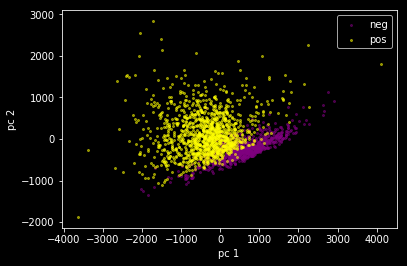

In [248]:
fig, ax = plt.subplots()
#X_new = X_new[np.where(df.y_consec_sig == False)[0],:]
neg = np.where(df[outcome_def] == False)[0]
pos = np.where(df[outcome_def] == True)[0]
ax.scatter(X_new[neg,0], X_new[neg,1], c='purple', label='neg', alpha=.5, s=4)
ax.scatter(X_new[pos,0], X_new[pos,1], c='yellow', label='pos', alpha=.5, s=4)
ax.legend()
ax.set_xlabel("pc 1")
ax.set_ylabel("pc 2")
plt.show()

In [208]:
tsne = TSNE(n_components=2, perplexity=30)
df_X = (df_X - df_X.mean()) / df_X.std()
X_new = tsne.fit_transform(df_X)

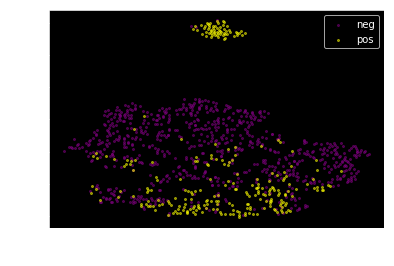

In [211]:
fig, ax = plt.subplots()
#X_new = X_new[np.where(df.y_consec_sig == False)[0],:]
neg = np.where(df_no_consec[outcome_def] == False)[0]
pos = np.where(df_no_consec[outcome_def] == True)[0]
ax.scatter(X_new[neg,0], X_new[neg,1], c='purple', label='neg', alpha=.5, s=4)
ax.scatter(X_new[pos,0], X_new[pos,1], c='yellow', label='pos', alpha=.5, s=4)
ax.legend()
ax.set_xlabel("dim 1")
ax.set_ylabel("dim 2")
plt.show()

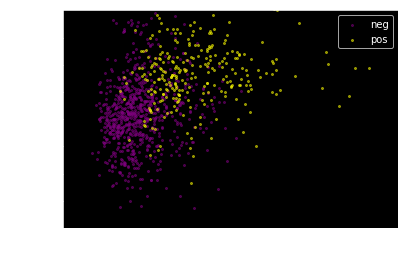

In [202]:
fig, ax = plt.subplots()
neg = np.where(df_no_consec[outcome_def] == False)[0]
pos = np.where(df_no_consec[outcome_def] == True)[0]
ax.scatter(df_no_consec['Y_max'].values[neg], df_no_consec['X_max_diff'].values[neg], c='purple', label='neg', alpha=.5, s=4)
ax.scatter(df_no_consec['Y_max'].values[pos], df_no_consec['X_max_diff'].values[pos], c='yellow', label='pos', alpha=.5, s=4)
ax.legend()
ax.set_ylim((-2000, 2000))
ax.set_xlim((0, 2000))
ax.set_xlabel("Y_max")
ax.set_ylabel("X_max_diff")
plt.show()

In [212]:
def extract_X_mat(df):
    p1 = max(df['X_peak_idx'].values)
    p2 = max(df['lifetime'].values - df['X_peak_idx'].values)
    n = df.shape[0]
    X_mat = np.zeros((n, p1 + p2)).astype(np.float32)
    X = df['X'].values
    for i in range(n):
        x = X[i]
        start = (p1 - df['X_peak_idx'].values[i])
        end = start + df['lifetime'].values[i]
        X_mat[i, start:end] = x
    X_mat = np.nan_to_num(X_mat)
    #X_mat -= np.min(X_mat)
    #X_mat /= np.std(X_mat)
    return X_mat

def extract_Y_mat(df):
    p1 = max(df['Y_peak_idx'].values)
    p2 = max(df['lifetime'].values - df['Y_peak_idx'].values)
    n = df.shape[0]
    Y_mat = np.zeros((n, p1 + p2)).astype(np.float32)
    Y = df['Y'].values
    for i in range(n):
        y = Y[i]
        start = (p1 - df['Y_peak_idx'].values[i])
        end = start + df['lifetime'].values[i]
        Y_mat[i, start:end] = y
    Y_mat = np.nan_to_num(Y_mat)
    #X_mat -= np.min(X_mat)
    #X_mat /= np.std(X_mat)
    return Y_mat

In [241]:
df_no_consec = df[df.y_consec_sig == False]
df_Y_mat = extract_Y_mat(df_no_consec)
df_X_mat = extract_X_mat(df_no_consec)
df_mat = np.concatenate((df_X_mat, df_Y_mat), axis=1)

In [242]:
from sklearn.decomposition import PCA
pca = PCA(n_components=50)
df_mat_pca = pca.fit_transform(df_mat)

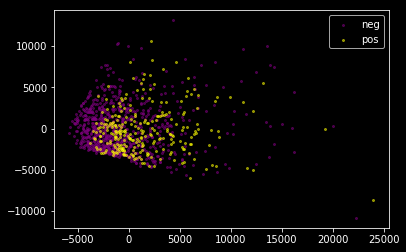

In [225]:
fig, ax = plt.subplots()
#X_new = X_new[np.where(df.y_consec_sig == False)[0],:]
neg = np.where(df_no_consec[outcome_def] == False)[0]
pos = np.where(df_no_consec[outcome_def] == True)[0]
ax.scatter(df_mat_pca[neg,0], df_mat_pca[neg,1], c='purple', label='neg', alpha=.5, s=4)
ax.scatter(df_mat_pca[pos,0], df_mat_pca[pos,1], c='yellow', label='pos', alpha=.5, s=4)
ax.legend()
plt.show()

In [238]:
df_mat_pca.shape

(1053, 10)

In [239]:
tsne = TSNE(n_components=2, perplexity=30)
df_mat_p = (df_mat - df_mat.mean()) / df_mat.std()
Y_new = tsne.fit_transform(df_mat_pca)

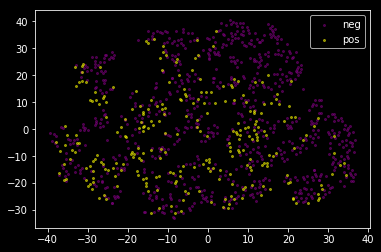

In [240]:
fig, ax = plt.subplots()
#X_new = X_new[np.where(df.y_consec_sig == False)[0],:]
neg = np.where(df_no_consec[outcome_def] == False)[0]
pos = np.where(df_no_consec[outcome_def] == True)[0]
ax.scatter(Y_new[neg,0], Y_new[neg,1], c='purple', label='neg', alpha=.5, s=4)
ax.scatter(Y_new[pos,0], Y_new[pos,1], c='yellow', label='pos', alpha=.5, s=4)
ax.legend()
plt.show()